In [1]:
import os
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from torchvision.utils import save_image
from util import stopwatch, get_stopwatch
import numpy as np
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

save_img_row_size = 8
label_list = "plane autos birds cats_ deer_ dogs_ frogs horse ships truck".split(" ")
def save_labels(labels, path):
    with open(path, 'w') as f:
        for i, label in enumerate(labels.detach().numpy()):
            l = np.where(label==1)[0][0]
            print(label_list[l], file=f, end=('\n' if (i+1) % save_img_row_size == 0 else ' '))
torch.manual_seed(7)

In [2]:
num_epochs = 500
batch_size = 100
num_labels = 10

sample_dir = 'cifar_aux_onehot_wider'
if not os.path.exists(sample_dir): os.makedirs(sample_dir)
    
fake_img_dir = os.path.join(sample_dir, 'fake_images')
if not os.path.exists(fake_img_dir): os.makedirs(fake_img_dir)

transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean=(0.5,0.5,0.5), std=(0.5,0.5,0.5))])
def denorm(x): return ((x+1)/2).clamp(0,1)

def one_hot(x):
    r = torch.zeros(num_labels)
    try: r[x] = 1
    except: r[x.item()] = 1
    return r
def one_hot_multi(x):
    r = torch.zeros([x.shape[0], num_labels] + list(x.shape[2:])).to(device)
    r.scatter_(1, x.unsqueeze(1), 1)
    return r
dataset = torchvision.datasets.CIFAR10(root='~/cifar10-data/', train=True, download=True,
                                   transform=transform) #, target_transform=one_hot) <- not using since using embedding

data_loader = torch.utils.data.DataLoader(dataset=dataset, batch_size = batch_size, shuffle=True)

Files already downloaded and verified


In [3]:
from matplotlib import pyplot as plt
show_i = 4
print("{} images of {}".format(len(dataset), dataset[1][0].shape))
print(dataset[show_i][1])
print(dataset[show_i][0].shape)
plt.imshow(denorm(dataset[show_i][0].permute(1,2,0)))

50000 images of torch.Size([3, 32, 32])
1
torch.Size([3, 32, 32])


In [4]:
latent_size = 64
image_size = 32 * 32
num_colors = 3
num_kernels = 32
embedding_size = 64

In [5]:
class Discriminator(nn.Module):
    def __init__(self, E):
        super(Discriminator, self).__init__()
        self.D1 = nn.Sequential(
                    # add label to each pixel in input. (10+3) * 32 * 32
                    nn.Conv2d(num_labels+num_colors, num_kernels, 2, 2, 0),
                    # 32x16x16
                    nn.LeakyReLU(0.2),
                    nn.Conv2d(num_kernels, num_kernels*2, 3, 2, 1),
                    # 64x8x8
                    nn.BatchNorm2d(num_kernels * 2),
                    nn.LeakyReLU(0.2),
                    nn.Conv2d(num_kernels*2, num_kernels*4, 2, 1),
                    # 128x7x7
                    nn.BatchNorm2d(num_kernels * 4),
                    nn.LeakyReLU(0.2),
                    nn.Conv2d(num_kernels*4, num_kernels*8, 2, 2),
                    # 256x3x3
                    nn.BatchNorm2d(num_kernels * 8),
                    nn.LeakyReLU(0.2))
        self.D2 = nn.Sequential(nn.Conv2d(num_kernels*8, 1, 3), nn.Sigmoid())
        self.C = nn.Linear(num_kernels * 8 * 3 * 3, num_labels)
        self.E = E
        
    def get_embedding(self, images, labels):
        embeddings = one_hot_multi(labels)
        embeddings_dups = embeddings.unsqueeze(dim=-1).unsqueeze(dim=-1).expand(embeddings.shape+images.shape[2:])
        d_inputs = torch.cat((images, embeddings_dups), 1)
        return self.D1(d_inputs)
    
    def forward(self, images, labels):
        e = self.get_embedding(images, labels)
        e_flat = e.view(-1, num_kernels * 8 * 3 * 3)
        # probability of being real, log(class probabilities)
        return self.D2(e), F.log_softmax(self.C(e_flat), dim=1)
E_D = nn.Embedding(num_labels, embedding_size)
D = Discriminator(E_D)
D = D.to(device)
D_losses = []

In [6]:
class Generator(nn.Module):
    def __init__(self, E):
        super(Generator, self).__init__()
        self.G = nn.Sequential(
                    nn.ConvTranspose2d(latent_size+num_labels, num_kernels*8, 3, 1, 0),
                    # 256x3x3
                    nn.BatchNorm2d(num_kernels*8),
                    nn.ReLU(),
                    nn.ConvTranspose2d(num_kernels*8, num_kernels*4, 2, 2, 1),
                    # 128x5x5
                    nn.BatchNorm2d(num_kernels*4),
                    nn.ReLU(),
                    nn.ConvTranspose2d(num_kernels*4, num_kernels*2, 2, 2, 0, 1),
                    # 64x9x9
                    nn.BatchNorm2d(num_kernels*2),
                    nn.ReLU(),
                    nn.ConvTranspose2d(num_kernels*2, num_kernels*3//2, 3, 2, 1),
                    nn.BatchNorm2d(num_kernels*3//2),
                    nn.ReLU(),
                    nn.ConvTranspose2d(num_kernels*3//2, num_kernels, 2, 1, 1),
                    # 32x16x16
                    nn.BatchNorm2d(num_kernels),
                    nn.ReLU(),
                    nn.ConvTranspose2d(num_kernels, num_colors, 2, 2, 0),
                    nn.Tanh())
        self.E = E
    
    def forward(self, labels, z=None):
        if z is None: z = torch.randn(labels.shape[0], latent_size)
        z = z.to(device)
        embeddings = one_hot_multi(labels)
        g_inputs = torch.cat((z, embeddings), 1) # batch_size * latent_dim
        g_inputs = g_inputs.unsqueeze(-1).unsqueeze(-1) # -> batch_size * latent_dim * 1 * 1 for DC generator
        return self.G(g_inputs)
E_G = nn.Embedding(num_labels, embedding_size)
G = Generator(E_G)
G = G.to(device)
G_losses = []

In [16]:
criterion = nn.BCELoss()
d_optimizer = torch.optim.Adam(D.parameters(), lr=0.0002)
g_optimizer = torch.optim.Adam(G.parameters(), lr=0.0002)

def reset_grad(): d_optimizer.zero_grad(); g_optimizer.zero_grad()

In [17]:
def save_generated_images(G, epoch, labels = None, z = None, nrow = 10):
    if labels is None:
        labels = torch.LongTensor([i//10 for i in range(100)]).to(device)
    fake_images = G(labels, z)
    save_image(denorm(fake_images), os.path.join(fake_img_dir, 'fake_images-{}.png'.format(epoch+1)), nrow=nrow)

In [7]:
from inception_score import inception_score
#G.load_state_dict(torch.load(os.path.join(sample_dir, 'G_cond_{}.ckpt'.format(419))))
G.eval()
def get_inception_score(G, num_in_each_label):
    labels = torch.LongTensor([i//num_in_each_label for i in range(num_in_each_label * num_labels)]).to(device)
    image_dataset = denorm(G(labels, None))
    #image_dataset= torch.utils.data.TensorDataset(images)
    #print(len(images))
    return inception_score(image_dataset, cuda=True, batch_size=32, resize=True, splits=10)
print(get_inception_score(G, 100))

/usr/local/lib/python3.5/dist-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")
/usr/local/lib/python3.5/dist-packages/torch/nn/functional.py:1961: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))
/home/ys2833/cv-final/steven/inception_score.py:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(x).data.cpu().numpy()


(2.596631889759265, 0.3425770972384244)


In [18]:
import pickle as pkl

total_step = len(data_loader)
demo_z = torch.randn(100, latent_size)
for epoch in range(num_epochs):
    stopwatch()
    pkl.dump({'D_losses': D_losses, 'G_losses': G_losses}, open(os.path.join(sample_dir, 'losses.pkl'), 'wb'))
    D_loss_this_epoch = []
    G_loss_this_epoch = []
    D_losses.append(D_loss_this_epoch)
    G_losses.append(G_loss_this_epoch)
    G.train()
    D.train()
    
    for i, (images, labels_cpu) in enumerate(data_loader):
        real_labels = torch.ones (batch_size, 1, 1, 1).to(device)
        fake_labels = torch.zeros(batch_size, 1, 1, 1).to(device)
        labels = labels_cpu.to(device)
        
        ## discriminator
        # input real images to discriminator
        images = images.to(device)
        outputs, class_probs = D(images, labels)
        d_loss_real = criterion(outputs, real_labels)
        c_loss_real = F.nll_loss(class_probs, labels)
        real_score = outputs
        
        # generate fake images and feed to discriminator
        fake_images = G(labels)
        outputs, class_probs = D(fake_images, labels)
        d_loss_fake = criterion(outputs, fake_labels)
        c_loss_fake = F.nll_loss(class_probs, labels)
        fake_score = outputs
        
        # compute total loss and backprop
        d_loss = d_loss_real + d_loss_fake + c_loss_fake + c_loss_real
        reset_grad()
        d_loss.backward()
        d_optimizer.step()
        
        ## generator
        # generate fake images and feed to discriminator
        fake_images = G(labels)
        outputs, class_probs = D(fake_images, labels)
        c_loss = F.nll_loss(class_probs, labels)
        
        # compute loss for generator and backprop
        g_loss = criterion(outputs, real_labels) + c_loss
        reset_grad()
        g_loss.backward()
        g_optimizer.step()
        
        if (i+1) % 25 == 0:
            # only gets a subsample of the losses but that's okay
            D_loss_this_epoch.append(d_loss.item())
            G_loss_this_epoch.append(g_loss.item())
            t = get_stopwatch()
            print('Epoch [{}/{}], [{}/{}] ({:.1f}s/{:.1f}s) dl({:.4f}) gl({:.4f}), D(x)={:.2f}, D(G(z))={:.2f}'
                  .format(epoch, num_epochs, i+1, total_step,
                          t, t*total_step/i,
                          d_loss.item(), g_loss.item(),
                          real_score.mean().item(), fake_score.mean().item()), end="\r")
    print("")
    if epoch == 0: save_image(denorm(images), os.path.join(sample_dir, 'real_images.png'))
    if epoch < 10 or \
       (epoch < 100 and (epoch+1) % 5 == 0) or \
       (epoch < 200 and (epoch+1) % 10 == 0) or \
       (epoch+1) % 20 == 0: save_generated_images(G, epoch, z = demo_z)
    
    if (epoch+1) % 20 == 0:
        torch.save(G.state_dict(), os.path.join(sample_dir, 'G_cond_{}.ckpt'.format(epoch)))
        torch.save(D.state_dict(), os.path.join(sample_dir, 'D_cond_{}.ckpt'.format(epoch)))


Epoch [0/500], [500/500] (41.0s/41.1s) dl(0.5714) gl(2.6188), D(x)=0.72, D(G(z))=0.06
Epoch [1/500], [500/500] (74.7s/74.8s) dl(0.1847) gl(3.3280), D(x)=0.96, D(G(z))=0.11
Epoch [2/500], [500/500] (74.9s/75.1s) dl(0.1141) gl(5.0341), D(x)=0.95, D(G(z))=0.04
Epoch [3/500], [500/500] (74.8s/75.0s) dl(0.1680) gl(3.1102), D(x)=0.95, D(G(z))=0.08
Epoch [4/500], [500/500] (75.0s/75.1s) dl(0.1589) gl(3.6358), D(x)=0.96, D(G(z))=0.09
Epoch [5/500], [500/500] (75.0s/75.2s) dl(0.3236) gl(4.5295), D(x)=0.83, D(G(z))=0.02
Epoch [6/500], [500/500] (75.0s/75.2s) dl(0.0408) gl(6.1530), D(x)=0.98, D(G(z))=0.02
Epoch [7/500], [500/500] (74.9s/75.1s) dl(0.2518) gl(4.0983), D(x)=0.95, D(G(z))=0.14
Epoch [8/500], [500/500] (74.8s/75.0s) dl(0.1809) gl(4.6378), D(x)=0.98, D(G(z))=0.10
Epoch [9/500], [500/500] (75.0s/75.2s) dl(0.1843) gl(5.9082), D(x)=0.93, D(G(z))=0.06
Epoch [10/500], [500/500] (74.9s/75.0s) dl(0.4160) gl(2.9506), D(x)=0.75, D(G(z))=0.01
Epoch [11/500], [500/500] (75.0s/75.1s) dl(0.5361) gl

Epoch [188/500], [500/500] (74.5s/74.7s) dl(0.1804) gl(5.2671), D(x)=0.87, D(G(z))=0.02
Epoch [189/500], [500/500] (74.5s/74.6s) dl(0.1967) gl(5.6375), D(x)=0.89, D(G(z))=0.05
Epoch [190/500], [500/500] (74.7s/74.9s) dl(0.5532) gl(4.0920), D(x)=0.69, D(G(z))=0.04
Epoch [191/500], [500/500] (74.5s/74.7s) dl(0.0917) gl(3.6734), D(x)=0.98, D(G(z))=0.06
Epoch [192/500], [500/500] (74.5s/74.6s) dl(0.1745) gl(4.3017), D(x)=0.95, D(G(z))=0.07
Epoch [193/500], [500/500] (74.5s/74.7s) dl(0.7457) gl(5.6689), D(x)=0.60, D(G(z))=0.02
Epoch [194/500], [500/500] (74.5s/74.6s) dl(0.2752) gl(2.6388), D(x)=0.97, D(G(z))=0.18
Epoch [195/500], [500/500] (74.5s/74.6s) dl(0.0982) gl(4.9632), D(x)=0.96, D(G(z))=0.04
Epoch [196/500], [500/500] (74.7s/74.9s) dl(0.2059) gl(6.6491), D(x)=0.85, D(G(z))=0.01
Epoch [197/500], [500/500] (74.6s/74.8s) dl(0.4662) gl(1.6910), D(x)=1.00, D(G(z))=0.26
Epoch [198/500], [500/500] (74.6s/74.7s) dl(0.2083) gl(2.5269), D(x)=0.98, D(G(z))=0.13
Epoch [199/500], [500/500] (74.8

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Epoch [412/500], [500/500] (74.6s/74.7s) dl(0.3028) gl(4.2517), D(x)=0.82, D(G(z))=0.03
Epoch [413/500], [500/500] (74.6s/74.7s) dl(0.3704) gl(2.4184), D(x)=0.97, D(G(z))=0.17
Epoch [414/500], [500/500] (74.6s/74.8s) dl(0.0595) gl(4.9586), D(x)=0.97, D(G(z))=0.03
Epoch [415/500], [500/500] (74.5s/74.7s) dl(0.2277) gl(4.6027), D(x)=0.86, D(G(z))=0.02
Epoch [416/500], [500/500] (74.5s/74.7s) dl(0.3263) gl(2.3551), D(x)=0.91, D(G(z))=0.14
Epoch [417/500], [500/500] (74.3s/74.4s) dl(0.2757) gl(5.7582), D(x)=0.83, D(G(z))=0.02
Epoch [418/500], [500/500] (74.2s/74.4s) dl(0.0589) gl(4.9265), D(x)=1.00, D(G(z))=0.05
Epoch [419/500], [500/500] (74.2s/74.3s) dl(0.0788) gl(4.4150), D(x)=0.96, D(G(z))=0.03
Epoch [420/500], [500/500] (74.3s/74.5s) dl(0.1710) gl(5.4088), D(x)=0.88, D(G(z))=0.02
Epoch [421/500], [500/500] (74.4s/74.6s) dl(0.2682) gl(2.8142), D(x)=0.99, D(G(z))=0.18
Epoch [422/500], [500/500] (74.5s/74.7s) dl(0.1458) gl(5.5721), D(x)=0.91, D(G(z))=0.03
Epoch [423/500], [500/500] (74.5

In [40]:
torch.save(G.state_dict(), os.path.join(sample_dir, 'G_cond_{}.ckpt'.format(epoch)))
torch.save(D.state_dict(), os.path.join(sample_dir, 'D_cond_{}.ckpt'.format(epoch)))

In [44]:
# [(image, [nearest_neighbours]), ...]
def generate_images(G, category, num):
    G.eval()
    fake_images = G(torch.LongTensor([category]*num).to(device))
    return denorm(fake_images).detach()

In [43]:
nearest_images = {}

truck


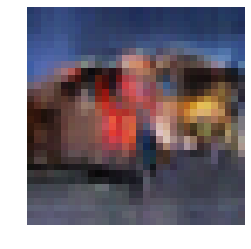

In [156]:
category = 9
height = 1
num = 1
print(label_list[category])
imgs = generate_images(G, category, num)
fig = plt.figure()
for i, img in enumerate(imgs):
    a=fig.add_subplot(height,len(imgs)//height,i+1)
    plt.imshow(img.cpu().permute(1,2,0).numpy())
    plt.axis('off')
nearest_images[category] = {'fake': imgs[0]}

fake_output = D.get_embedding(imgs, torch.LongTensor([category]*num).to(device))
fake_output = fake_output.reshape(fake_output.shape[0], -1)

In [157]:
closest = [[] for i in range(num)]
topX = 3
total_step = len(dataset)
stopwatch()
test_category = category
print(label_list[test_category])
for i, (image, label) in enumerate(dataset):
    if label != test_category: continue
    output = D.get_embedding(image.unsqueeze(0).to(device), torch.LongTensor([label]).to(device))
    output = output.reshape(output.shape[0], -1)
    diffs = torch.sum((fake_output - output)**2, dim=1).data.tolist()
    for j, diff in enumerate(diffs):
        closest[j].append((i, diff))
        closest[j].sort(key=lambda x : x[1])
        closest[j] = closest[j][:topX]
    if (i+1) % 25 == 0:
        t = get_stopwatch()
        print('[{}/{}] ({:.1f}s/{:.1f}s)'.format(i+1, total_step, t, t*total_step/i), end="\r")
print("")

truck
[49250/50000] (15.4s/15.6s)


[1/1] (0.1s/57.1s)


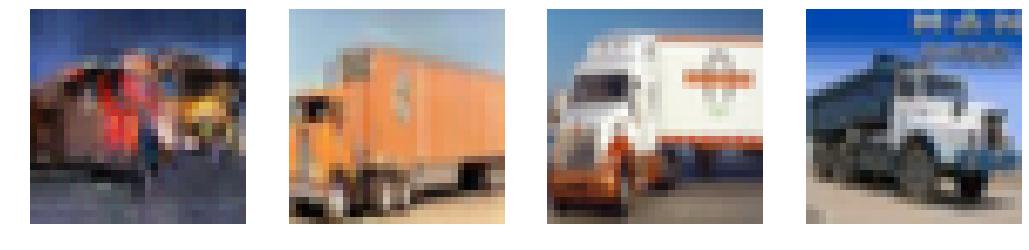

In [158]:
fig = plt.figure(figsize=(16, 16), dpi= 80)
stopwatch()
total_step = len(imgs)
nearest_images[category]['reals'] = []
for i, img in enumerate(imgs):
    a=fig.add_subplot(len(imgs),topX+1,1+i*(topX+1))
    plt.imshow(img.cpu().permute(1,2,0).numpy())
    plt.axis('off')
    for j, (c_id, _c_dist) in enumerate(closest[i]):
        real_img, _real_img_label = dataset[c_id]
        nearest_images[category]['reals'].append(real_img)
        a=fig.add_subplot(len(imgs),topX+1,1+i*(topX+1)+1+j)
        plt.imshow(denorm(real_img.cpu().permute(1,2,0)))
        plt.axis('off')
    t = get_stopwatch()
    print('[{}/{}] ({:.1f}s/{:.1f}s)'.format(i+1, total_step, t, t*total_step/(i+0.001)), end="\r")
print("")

In [161]:
import pickle as pkl
pkl.dump(nearest_images, open(os.path.join(sample_dir, 'nearest.pkl'), 'wb'))

In [172]:
nearest_list = []
for i in range(num_labels):
    nearest_list.append(nearest_images[i]['fake'].unsqueeze(0))
for j in range(3):
    for i in range(num_labels):
        nearest_list.append(nearest_images[i]['reals'][j].unsqueeze(0).to(device))
nearest_list = torch.cat(nearest_list, dim=0)
print(nearest_list.shape)
save_image(nearest_list, os.path.join(sample_dir, 'nearest.png'), nrow=num_labels)

torch.Size([40, 3, 32, 32])


In [173]:
def save_generated_images(G, labels = None, z = None, num_rows = 10, path=os.path.join(sample_dir, 'fake_images.png')):
    if labels is None:
        labels = torch.LongTensor([i % num_labels for i in range(num_labels * num_rows)]).to(device)
    fake_images = G(labels, z)
    save_image(denorm(fake_images), path, nrow=10)
save_generated_images(G, num_rows=5)